In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
from functools import reduce
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()


from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (8, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("theta-rhythmicity")
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
data, labels, colors, queries = load_data_frames()

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [6]:
theta_action = actions['theta-rhythmicity']
theta_results = pd.read_csv(theta_action.data_path('results'))

In [7]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [8]:
data = data.drop(columns='theta_score').merge(theta_results, how='left')

In [9]:
data = data.merge(stim_results, how='left')

In [10]:
data['stim_strength'] = data.stim_p_max / data.theta_peak

In [11]:
keys = [
    'theta_score',
    'theta_bandpower',
    'theta_relpower',
    'theta_relpeak',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'stim_bandpower',
    'stim_relpower',
    'stim_relpeak',
    'stim_half_width',
    'stim_p_max',
    'stim_strength',
]

In [12]:
results, labels = make_paired_tables(data, keys)

In [13]:
results['gridcell']['theta_relpeak']

entity  unit_idnum  channel_group    date  Baseline I     11 Hz  \
51     1833           8              0   20719    1.248894       NaN   
85     1833          13              0   20719         NaN  0.037071   
86     1833          14              0   20719         NaN  0.107253   
58     1833          23              0  200619    1.032539       NaN   
127    1833          26              0  200619         NaN       NaN   
..      ...         ...            ...     ...         ...       ...   
139    1849         835              4  150319         NaN       NaN   
43     1849         851              5   60319    2.999367       NaN   
65     1849         932              7  280219    1.869360       NaN   
74     1849         937              7  280219         NaN  0.264037   
105    1849         939              7  280219         NaN       NaN   

     Baseline II     30 Hz  
51           NaN       NaN  
85      1.287301  0.176807  
86      1.573884       NaN  
58           NaN       NaN  
127     0.851083  0.265955  
..           ...       ...  
139          NaN  2.182959  
43           NaN       NaN  
65           NaN       NaN  
74           NaN       NaN  
105     2.499672       NaN  

[137 rows x 8 columns]

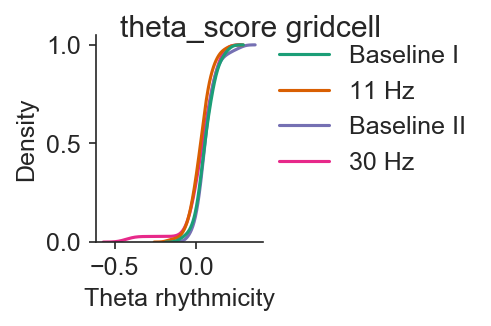

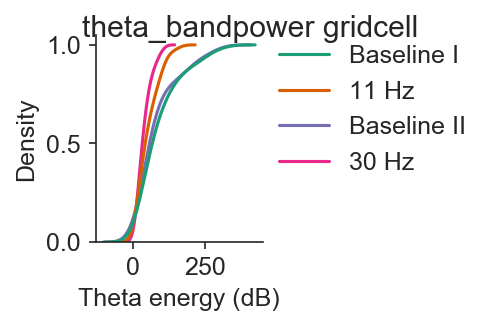

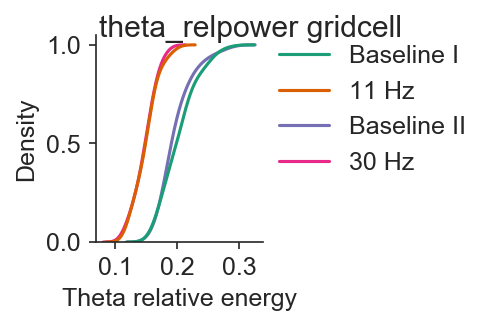

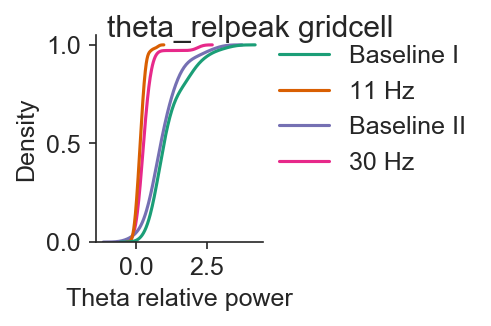

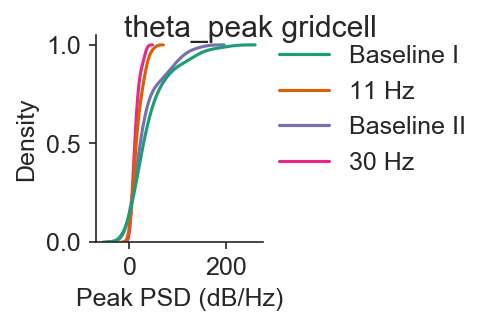

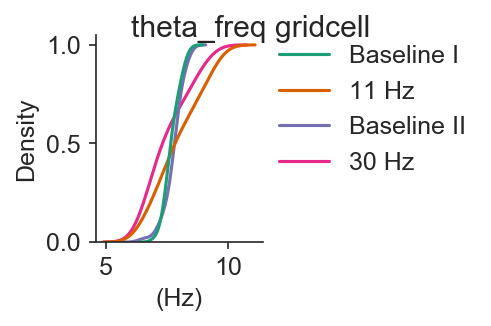

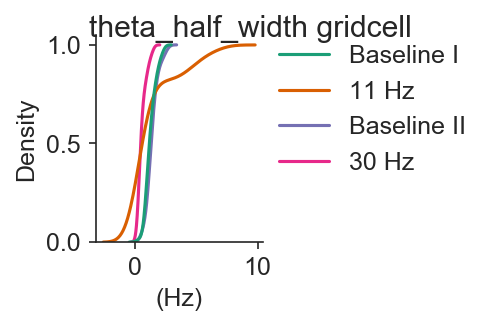

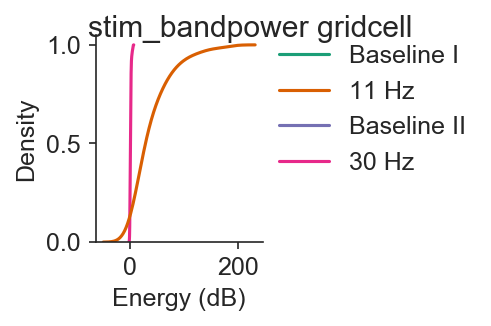

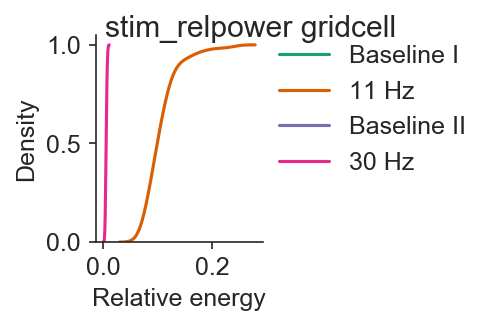

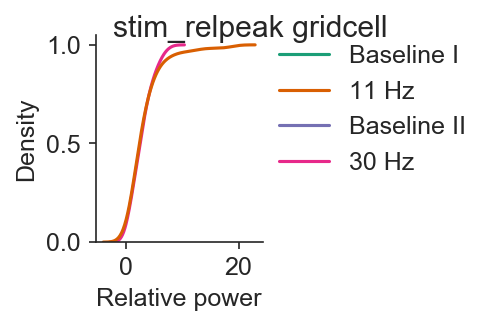

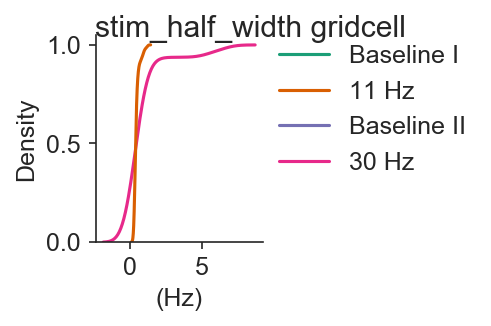

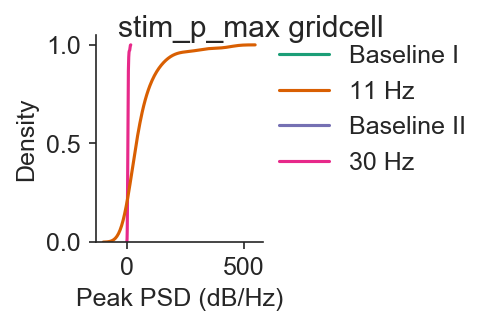

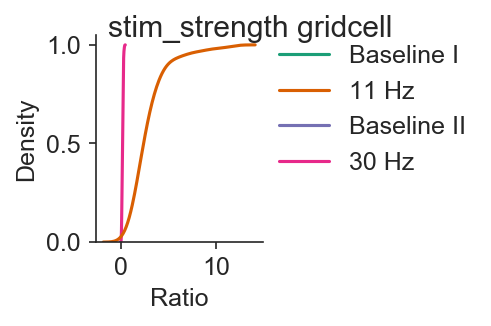

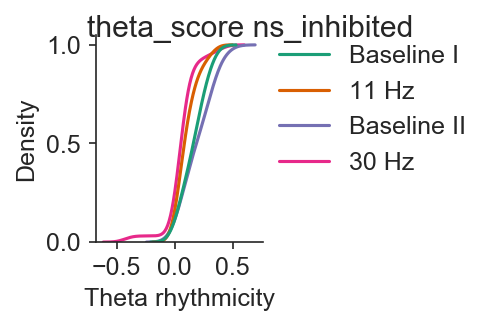

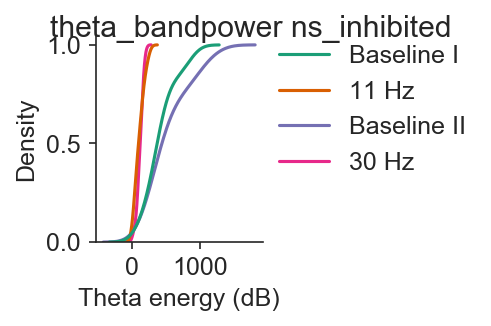

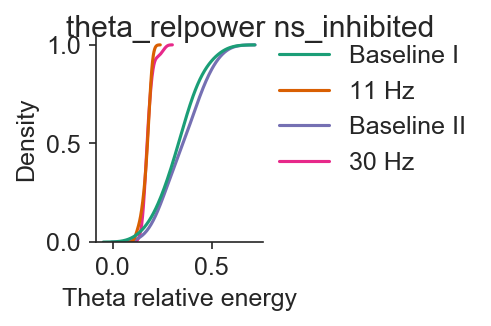

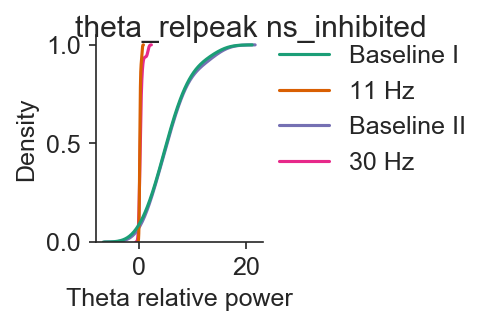

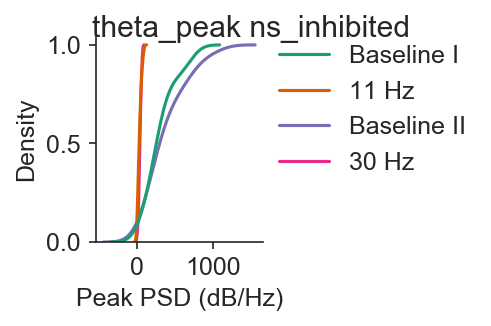

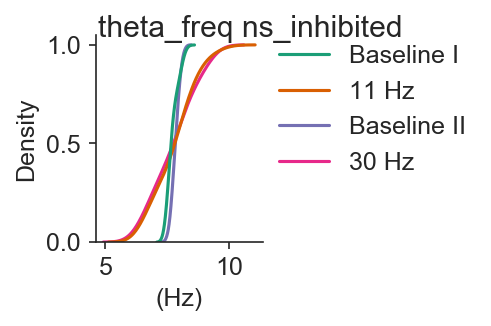

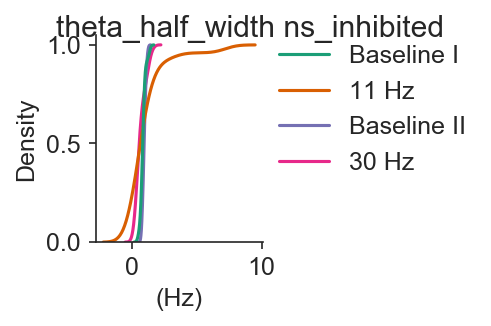

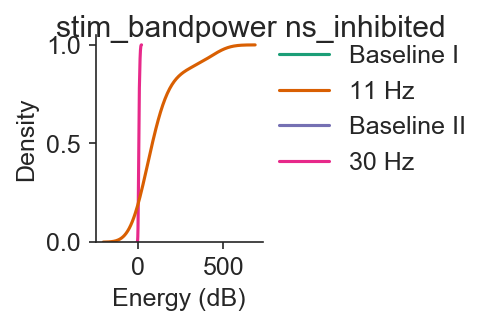

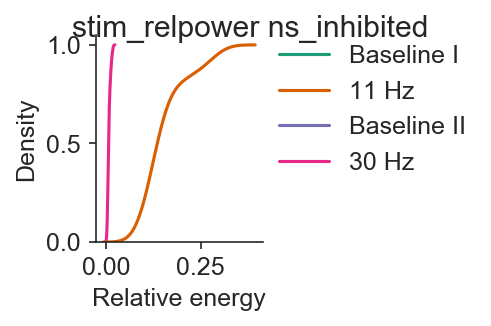

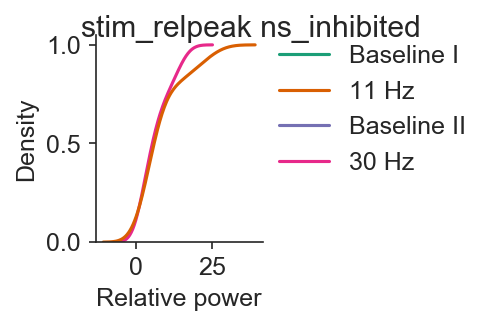

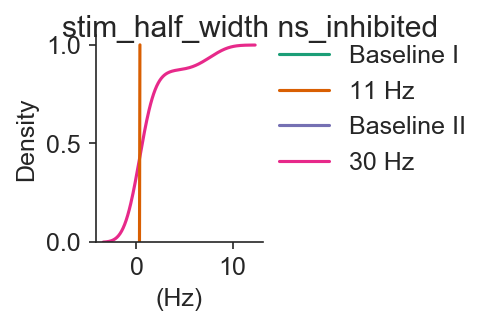

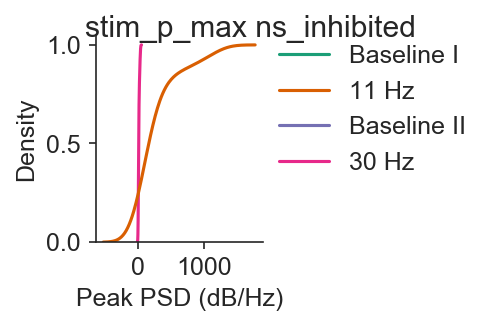

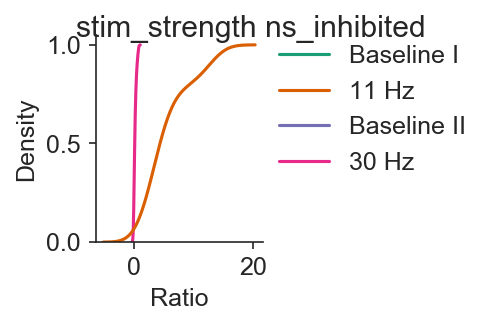

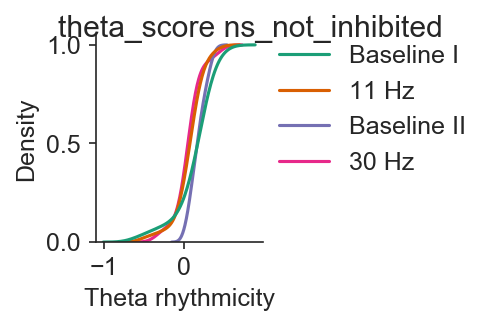

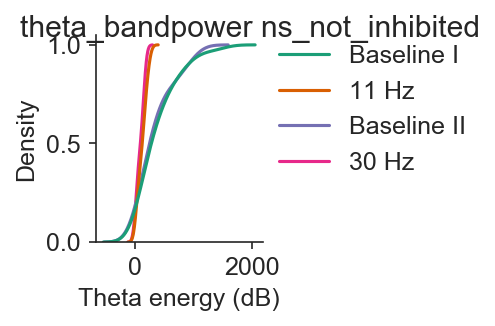

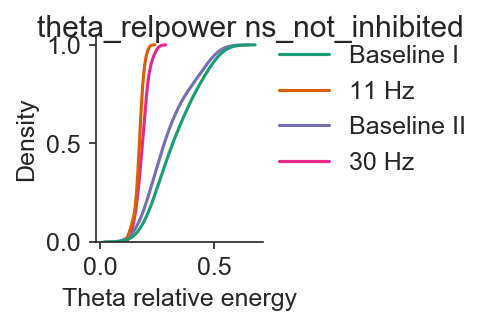

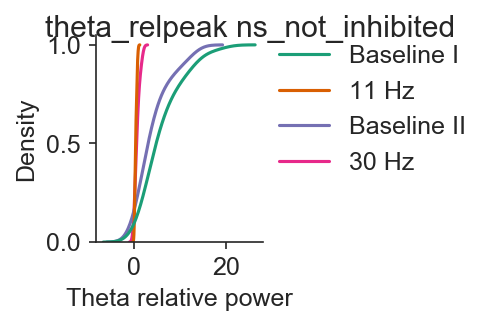

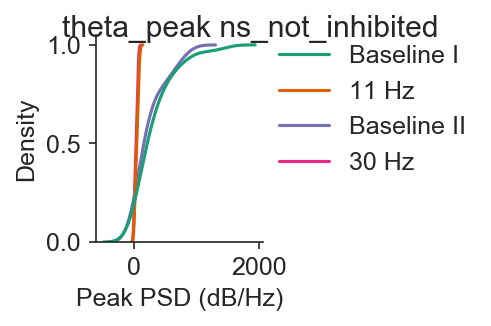

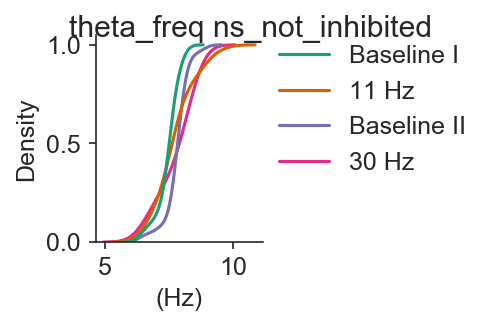

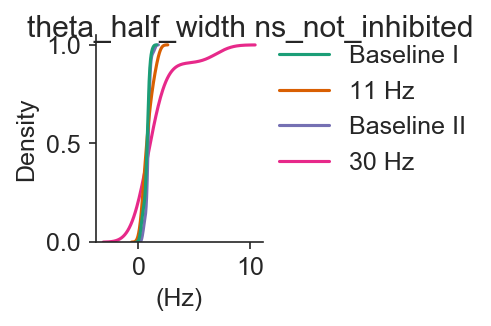

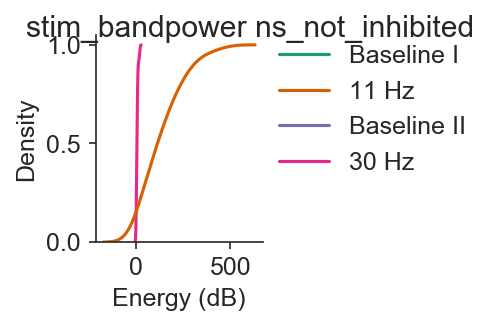

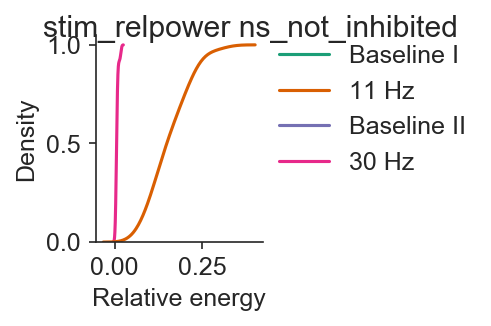

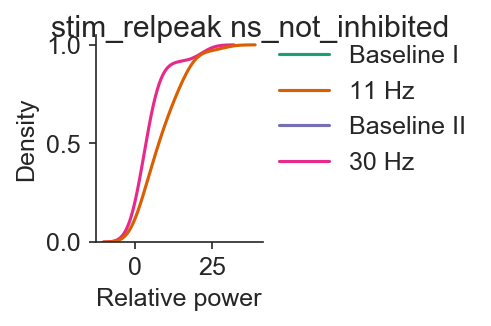

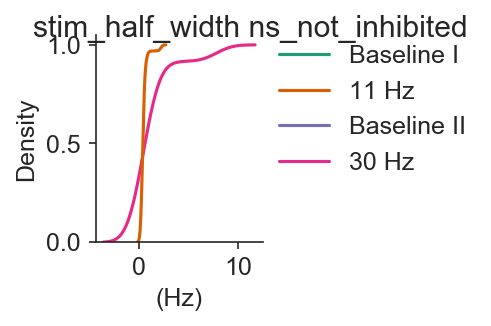

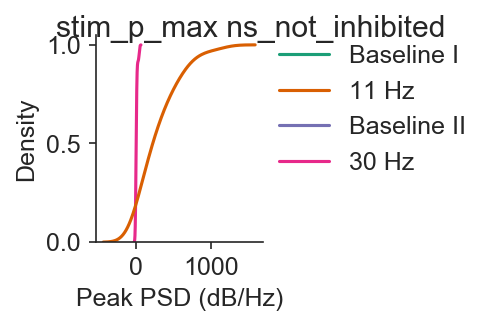

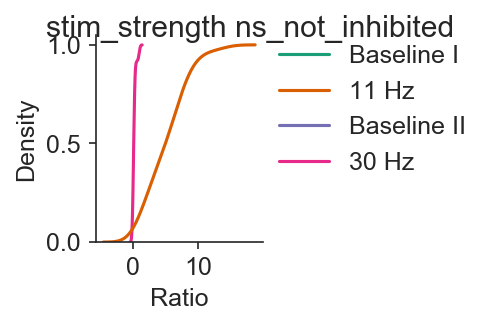

In [14]:
xlabel = {
    'theta_score': 'Theta rhythmicity',
    'theta_bandpower': 'Theta energy (dB)',
    'theta_relpower': 'Theta relative energy',
    'theta_relpeak': 'Theta relative power',
    'theta_peak': 'Peak PSD (dB/Hz)',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
    'stim_bandpower': 'Energy (dB)',
    'stim_relpower': 'Relative energy',
    'stim_relpeak': 'Relative power',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak PSD (dB/Hz)',
    'stim_strength': 'Ratio',
}
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in keys:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
#         plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'theta-rhythmicity-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

# stats

In [ ]:
stats = {}
for cell_type, result in results.items():
    stats[cell_type], _ = make_statistics_table(result, labels)

In [ ]:
stats['gridcell']

In [ ]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [ ]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

## psd

In [ ]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [ ]:
coher = pd.read_feather(output_path / 'data' / 'spike_psd.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [ ]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

In [ ]:
results['gridcell']['theta_relpeak']

In [ ]:
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,1.5))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
#         ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
#         ax.set_ylim(-30, 0)
    axs[0].set_ylabel('PSD')
    despine()
    figname = f'spike-psd-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [ ]:
action = project.require_action("theta-rhythmicity")

In [ ]:
copy_tree(output_path, str(action.data_path()))

In [ ]:
septum_mec.analysis.registration.store_notebook(action, "20-theta-rhythmicity.ipynb")